# Exploring the VGG16 and Xception Networks

State-of-the-art deep networks have millions of parameters and often takes days to train, even with clusters of high-power GPUs. Unless you have time and lots of cloud credits to burn, reproducing these results is not possible. Fortunately, the `keras` package has many excellent *pre-trained* networks that achieve state-of-the-art performance.  By *pre-trained*, we mean that the weights have already been trained and you can just load the network and weights.  We can then use these networks for image predictions and other research problems.

In this demo, we will explore one of two possible state-of-the-art pre-trained deep networks in the `keras` package: VGG16 and Xception.  The VGG16 network was first described in the paper:

> Karen Simonyan, Andrew Zisserman, [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556), arxiv 2014

The network was produced by the [Visual Geometry Group](http://www.robots.ox.ac.uk/~vgg/research/very_deep/) at Oxford University and obtained first and second place in the ImageNet 2014 challenge.  The XCeption network is described in

> François Chollet, [Xception: Deep Learning with Depthwise Separable Convolutions](https://arxiv.org/abs/1610.02357), arxiv 2016.

This network is slightly more recent, obtains slightly better performance and requires a smaller download.  But, it has many more layers.  The python notebook is setup to use either.

In this demo, you will see how to:
* Load a pre-trained network in the `keras` package
* Make predictions on new images with the network
* Obtain outputs of intermediate layers.

## Loading the Network

We first load the `tensorflow` package. 

In [1]:
import tensorflow as tf

Then, we import some other standard packages

In [2]:
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

Next, we load several sub-packages specific for the VGG16 or Xception networks.  A complete list of the pre-trained networks available are given on [keras application page](https://keras.io/applications/).

In [3]:
# Select 'xception' or 'vgg16'
pre_trained = 'vgg16'

# Load appropriate packages
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
if pre_trained == 'xception':
    from tensorflow.keras.applications.xception import decode_predictions, preprocess_input
elif pre_trained == 'vgg16':
    from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input    
else:
    raise Exception("Unknown model")

We now download the model with the pre-trained weights.  This can several minutes if you have not downloaded it before since it will fetch the `h5` model description file from the keras website.  Note the file is very large ~500 MB.  So, make sure you have disk space.  If not, consider doing this in the cloud, for example, on Google Cloud Platform.

In [4]:
if pre_trained == 'xception':
    model = Xception(weights='imagenet',input_shape=(299,299,3))
else:
    model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 176s 0us/step


The model.summary() page shows that the network has a large number of layers.  As is typical, the initial layers are convolutional with max pooling.  The last layers flatten the outputs and then go through two fully connected layers.  Note that the network has > 138 million parameters!

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Loading Test Images

We illustrate the network on a test set of elephant images.  We will assume that we have found 10 images and stored them in a directory,

    elephant/elephant_0000.jpg
    elephant/elephant_0001.jpg
    ...
    elephant/elephant_0009.jpg
    
Each image must be color with shape that matches the VGG16 input shape `(224,224,3)`.  You can follow the [Flicker API demo](flickr_images.ipynb) to create this dataset.

First, we create an empty matrix that will contain the batch of 10 images.

In [6]:
model.input_shape

(None, 224, 224, 3)

In [7]:
batch_size = 10
nrow = model.input_shape[1]
ncol = model.input_shape[2]
nchan = model.input_shape[3]
batch_shape = (batch_size,nrow,ncol,nchan)
x = np.zeros(batch_shape)

Then, we load the images into the batch.

In [8]:
class_name = 'elephant'
for i in range(batch_size):    
    fn = '{0:s}/{1:s}_{2:04d}.jpg'.format(class_name,class_name, i)  
    x[i,:,:,:] = image.load_img(fn, target_size=(nrow, ncol))

We can display a few of the images.  Note that some of the images were cropped in the process of resizing the image.

In [9]:
# Display the image
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.  
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

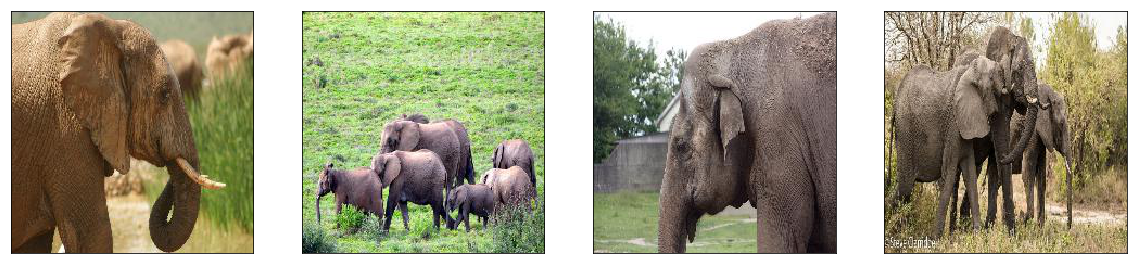

In [10]:
plt.figure(figsize=(20,20))
nplot = 4
for i in range(nplot):    
    plt.subplot(1,nplot,i+1)
    disp_image(x[i,:,:,:])

## Making Predictions on the Images

Now that we have created a batch of images, we can use the network to make predictions on the class.  First, the images must be pre-processed before running in VGG16 or Xception.

In [11]:
x = preprocess_input(x)

We then run the images through the network to make the predictions.  The `decode_predictions` translates the outputs into a data structure that we can interpret.

In [12]:
preds = model.predict(x)
preds_decoded = decode_predictions(preds, top=3)

40960/35363 [==================================] - 0s 1us/step


For each image `i` in the batch, `preds_decoded[i][j]` is a data record for the `j-th` most likely prediction.  The data record has the fields:
* `preds_decoded[i][j][0]`:  A class index
* `preds_decoded[i][j][1]`:  A class name, like `African elephant`
* `preds_decoded[i][j][2]`:  A class probability, between 0 and 1.

We display the decoded results as a pandas dataframe. 

In [13]:
ntop = 3
res_dict = {}
for i in range(ntop):
    class_name = []
    class_prob = []
    for j in range(batch_size):
        class_name.append(preds_decoded[j][i][1])
        class_prob.append(preds_decoded[j][i][2])

    name_col = str('class %d' % i)
    prob_col = str('prob %d' % i)
    res_dict[name_col] = class_name
    res_dict[prob_col] = class_prob
    
df = pd.DataFrame(data=res_dict)
df

,class 0,prob 0,class 1,prob 1,class 2,prob 2
0,African_elephant,0.519173,tusker,0.362482,Indian_elephant,0.118341
1,African_elephant,0.839397,Indian_elephant,0.092139,tusker,0.051893
2,Indian_elephant,0.677948,tusker,0.298737,African_elephant,0.023209
3,tusker,0.704182,African_elephant,0.262835,Indian_elephant,0.032978
4,African_elephant,0.908721,tusker,0.064473,Indian_elephant,0.026301
5,Indian_elephant,0.688414,African_elephant,0.245130,tusker,0.066410
6,African_elephant,0.656001,Indian_elephant,0.258525,tusker,0.085456
7,Indian_elephant,0.772432,African_elephant,0.126645,tusker,0.081386
8,African_elephant,0.628843,tusker,0.284775,Indian_elephant,0.086360
9,African_elephant,0.847303,tusker,0.134612,Indian_elephant,0.015840


## Get Intermediate Outputs

It is often useful to look at the outputs of intermediate layers.  This is easily done in `keras`.  Suppose we want to look at the outputs of `fc1` and `block4_conv2`.  Then, we create a new model, `model_int` with these two outputs as follows:

In [19]:
from tensorflow.keras.models import Model

# Construct list of layers
if pre_trained == 'vgg16':
    layer_names = ['block4_conv2', 'fc1']
else:
    layer_names = ['block12_sepconv2_act','block13_sepconv2_act']
out_list = []
for name in layer_names:
    out_list.append(model.get_layer(name).output)

# Create the model with the intermediate layers
model_int = Model(inputs=model.input, outputs=out_list)

We then run `predict` method to get the outputs with the inputs `x`.

In [20]:
y = model_int.predict(x)

The output `y` is a list with two outputs -- one for each layer.  We print the CDF of the output of the values from each layer.  We observe a key feature of the outputs.  About 75% of the coefficients are zero, meaning that deep network creates *sparse* representations.

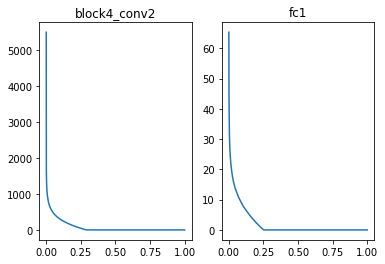

In [21]:
ny = len(y)
for ilayer in range(ny):
    y1 = np.sort(y[ilayer].ravel())
    n1 = len(y1)
    
    plt.subplot(1,ny,ilayer+1)
    plt.plot(np.arange(n1)/n1, y1[::-1])
    plt.title(layer_names[ilayer])

## Let us look at selected output channels at different layers

In [22]:
# Construct list of layers
if pre_trained == 'vgg16':
    layer_names = ['block1_conv1', 'block1_pool', 'block2_pool', 'block3_pool', 'block4_pool','block5_pool']
else:
    layer_names = ['block12_sepconv2_act','block13_sepconv2_act']
out_list = []
for name in layer_names:
    out_list.append(model.get_layer(name).output)

# Create the model with the intermediate layers
model_int = Model(inputs=model.input, outputs=out_list)
y = model_int.predict(x)
    

In [23]:
print(y[0].shape)

(10, 224, 224, 64)


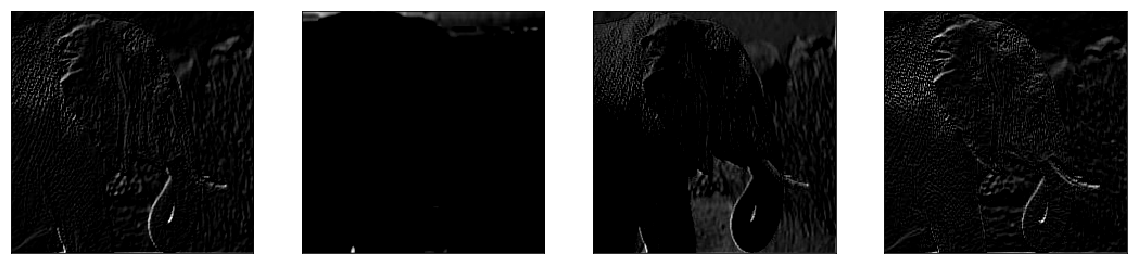

In [24]:

plt.figure(figsize=(20,20))
nplot = 4
for i in range(nplot):    
    plt.subplot(1,nplot,i+1)
    disp_image(y[0][0,:,:,i])

In [25]:
print(y[1].shape)

(10, 112, 112, 64)


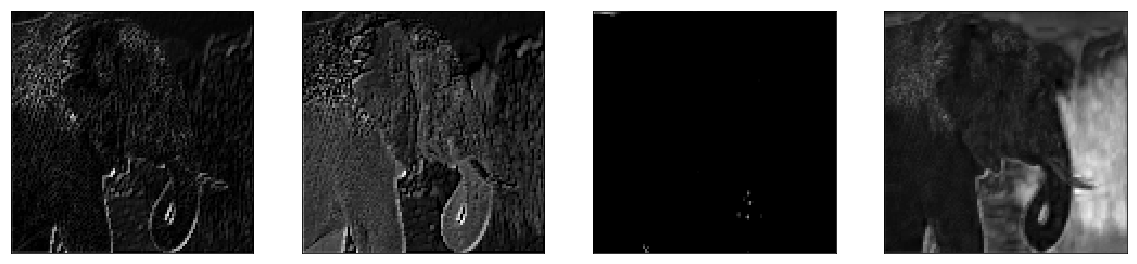

In [26]:

plt.figure(figsize=(20,20))
nplot = 4
for i in range(nplot):    
    plt.subplot(1,nplot,i+1)
    disp_image(y[1][0,:,:,i])

In [27]:
print(y[2].shape)

(10, 56, 56, 128)


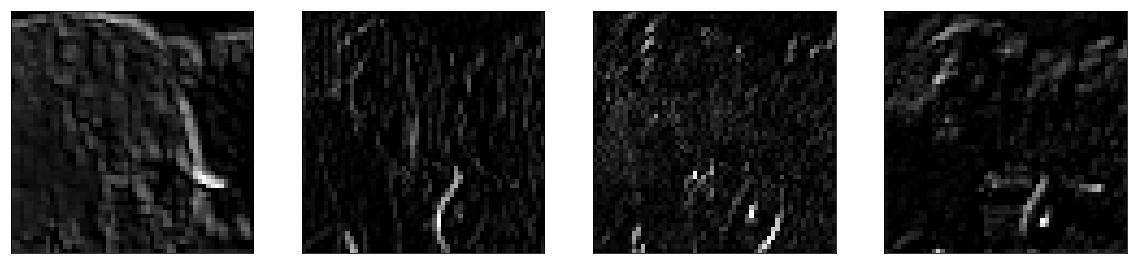

In [28]:

plt.figure(figsize=(20,20))
nplot = 4
for i in range(nplot):    
    plt.subplot(1,nplot,i+1)
    disp_image(y[2][0,:,:,i])

In [29]:
print(y[3].shape)

(10, 28, 28, 256)


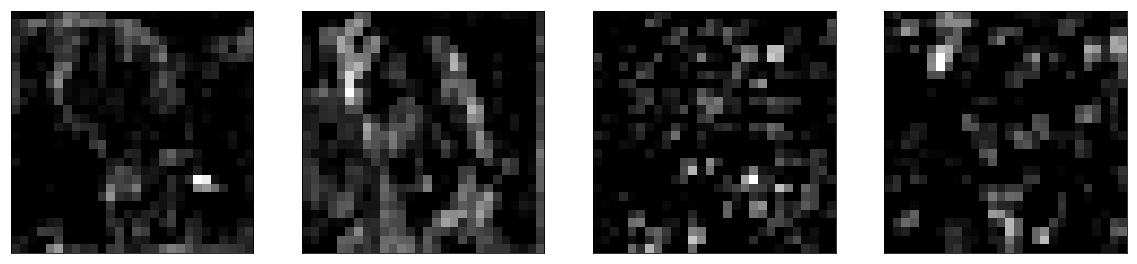

In [30]:

plt.figure(figsize=(20,20))
nplot = 4
for i in range(nplot):    
    plt.subplot(1,nplot,i+1)
    disp_image(y[3][0,:,:,i])

In [31]:
print(y[4].shape)

(10, 14, 14, 512)


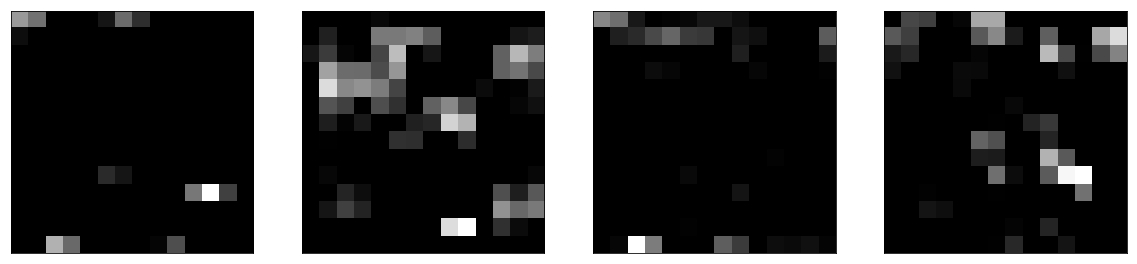

In [32]:
plt.figure(figsize=(20,20))
nplot = 4
for i in range(nplot):    
    plt.subplot(1,nplot,i+1)
    disp_image(y[4][0,:,:,i])

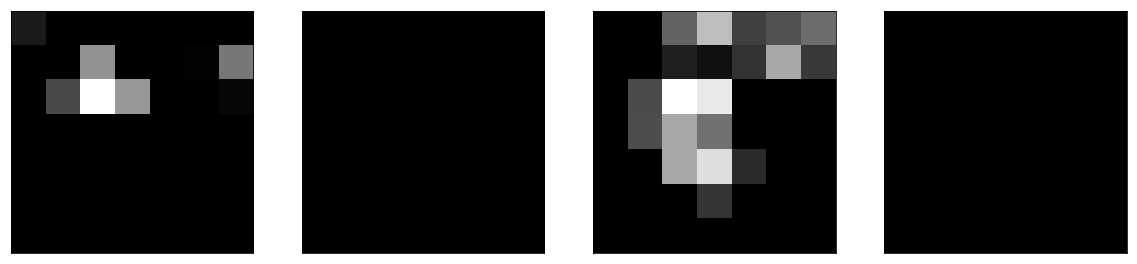

In [33]:
plt.figure(figsize=(20,20))
nplot = 4
for i in range(nplot):    
    plt.subplot(1,nplot,i+1)
    disp_image(y[5][0,:,:,i])

## In-Class Excerise

Find any image of your choice and use the pre-trained network to make a prediction.
* Download the image to your directory
* Load it into an image batch
* Predict the class label and decode the predictions